# Richards model prediction of Covid-19 for Cuba

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import pymc3 as pm
import arviz as az

## Load data

In [3]:
# Global parameters
country = 'Cuba'
ndays_limit = 58
epidemic_start = 10
x_data_label = 'days_since_{}'.format(epidemic_start)

# loading data
oper_file_path1 = 'data/cuba_data.csv'
df_input = pd.read_csv(oper_file_path1, sep=',', decimal='.', error_bad_lines=False, parse_dates=['date'])
df_input.index = df_input['date']

# Prepare data for model training
df = df_input[df_input['confirmed'] > epidemic_start][['date', 'confirmed', 'new_cases']].copy()
df.columns = ['date', 'acumulado', 'new_cases']
df[x_data_label] = list(np.arange(df.shape[0]))
print(df.tail(10))

                 date  acumulado  new_cases  days_since_10
date                                                      
2020-05-07 2020-05-07       1741         12             50
2020-05-08 2020-05-08       1754         13             51
2020-05-09 2020-05-09       1766         12             52
2020-05-10 2020-05-10       1783         17             53
2020-05-11 2020-05-11       1804         21             54
2020-05-12 2020-05-12       1810          6             55
2020-05-13 2020-05-13       1830         20             56
2020-05-14 2020-05-14       1840         10             57
2020-05-15 2020-05-15       1862         22             58
2020-05-16 2020-05-16       1872         10             59


## Split data into: train and test

In [5]:
df_train = df.loc['2020-03-18':'2020-05-14']
df_test = df.loc['2020-05-15':'2020-05-16']
df_test

,date,acumulado,new_cases,days_since_10
date,,,,
2020-05-15,2020-05-15,1862,22,58
2020-05-16,2020-05-16,1872,10,59


## Model fit

In [6]:
x_values = df_train[x_data_label].values
y_values = df_train.acumulado.astype('float64').values
dt_until = str(df_train[df_train[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]).replace('-', '')
with pm.Model() as richards_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)
    K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
    rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
    a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
    x0 = pm.Uniform('x0', 1, 200, testval=15)
    T = pm.Uniform('T', 1, 3, testval=1.2)
    R0 = pm.Deterministic('R0', np.exp(rate * T))

    # Create likelihood for data
    x_data = pm.Data("x_data", x_values)
    y_data = pm.Data("y_data", y_values)
    mu = K * (1 + np.exp(-rate * a * (x_data - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
    y = pm.Normal('y', mu=mu, tau=sigma, observed=y_data)
    
with richards_model:
    
    # Sample posterior
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(4000, tune=4000, cores=7, start=start, target_accept=.95, random_seed=1234)

logp = -249.08, ||grad|| = 49.668: 100%|██████████| 78/78 [00:00<00:00, 2175.17it/s]       
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [T, x0, a, rate, K, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 56000/56000 [03:17<00:00, 283.21draws/s]
The acceptance probability does not match the target. It is 0.9033655051062789, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


## Model summary

In [7]:
az.summary(az.from_pymc3(trace))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
rate,0.276,0.028,0.225,0.331,0.000,0.000,6496.0,6412.0,6673.0,9299.0,1.0
sigma[0],0.006,0.001,0.004,0.009,0.000,0.000,17312.0,17312.0,17141.0,16554.0,1.0
K,2000.482,14.232,1973.958,2027.299,0.146,0.103,9467.0,9460.0,9491.0,13244.0,1.0
a,0.313,0.040,0.239,0.387,0.000,0.000,6716.0,6716.0,6628.0,9360.0,1.0
x0,27.315,0.183,26.971,27.661,0.002,0.001,8189.0,8189.0,8168.0,12528.0,1.0
T,1.993,0.583,1.103,2.988,0.004,0.003,22496.0,22123.0,20337.0,14013.0,1.0
R0,1.759,0.308,1.290,2.290,0.002,0.002,17012.0,16076.0,16755.0,13866.0,1.0


In [8]:
pm.backends.tracetab.trace_to_dataframe(trace)

,rate,sigma__0,K,a,x0,T,R0
0,0.246789,0.008911,1975.134558,0.359166,27.286851,2.438822,1.825538
1,0.247534,0.008244,2005.945497,0.347184,27.563879,1.597792,1.485138
2,0.237422,0.006068,1974.770679,0.377580,27.493898,1.815905,1.539005
3,0.229883,0.006499,1970.132189,0.395462,27.604827,1.477439,1.404439
4,0.321182,0.006567,2010.389285,0.257305,27.092193,2.382722,2.149613
...,...,...,...,...,...,...,...
27995,0.332792,0.005719,2032.107035,0.239225,27.113851,1.542401,1.670793
27996,0.320763,0.005905,2020.720096,0.256925,27.209252,1.205091,1.471893
27997,0.311292,0.005671,2014.136454,0.266062,27.038143,1.113776,1.414406
27998,0.319149,0.005494,2007.298852,0.263926,27.083733,1.268068,1.498857


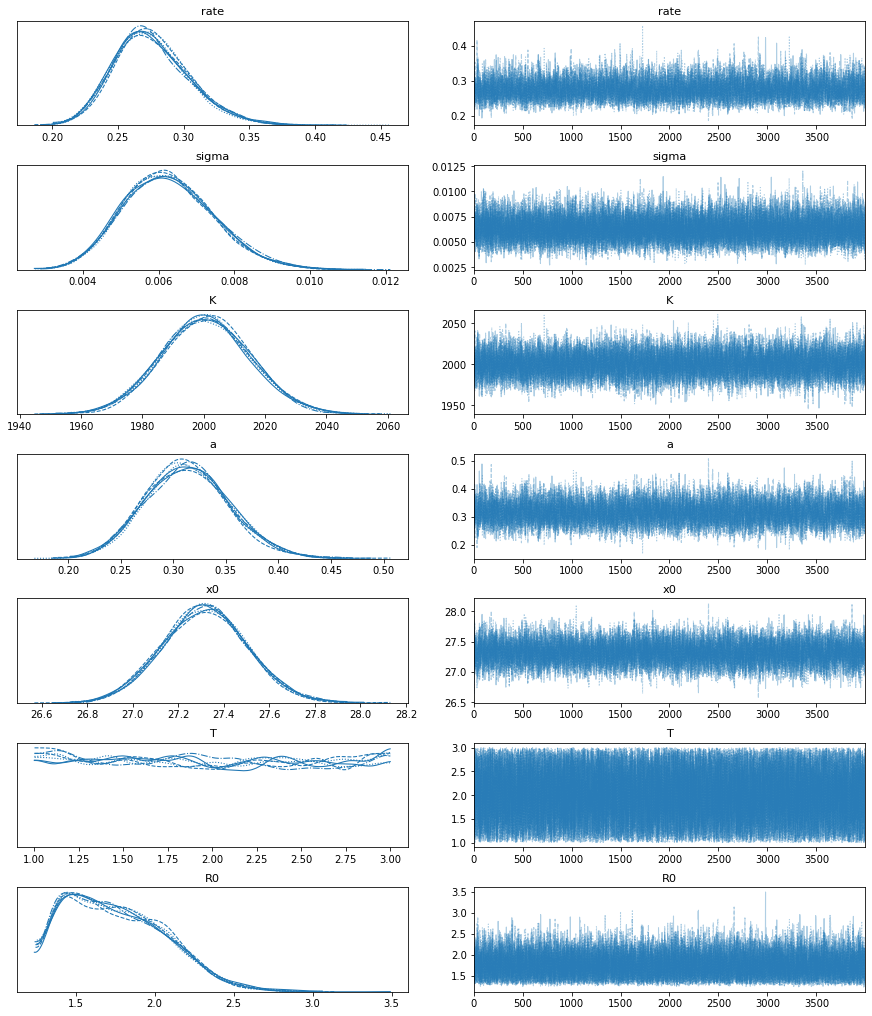

In [9]:
az.plot_trace(trace, compact=True);

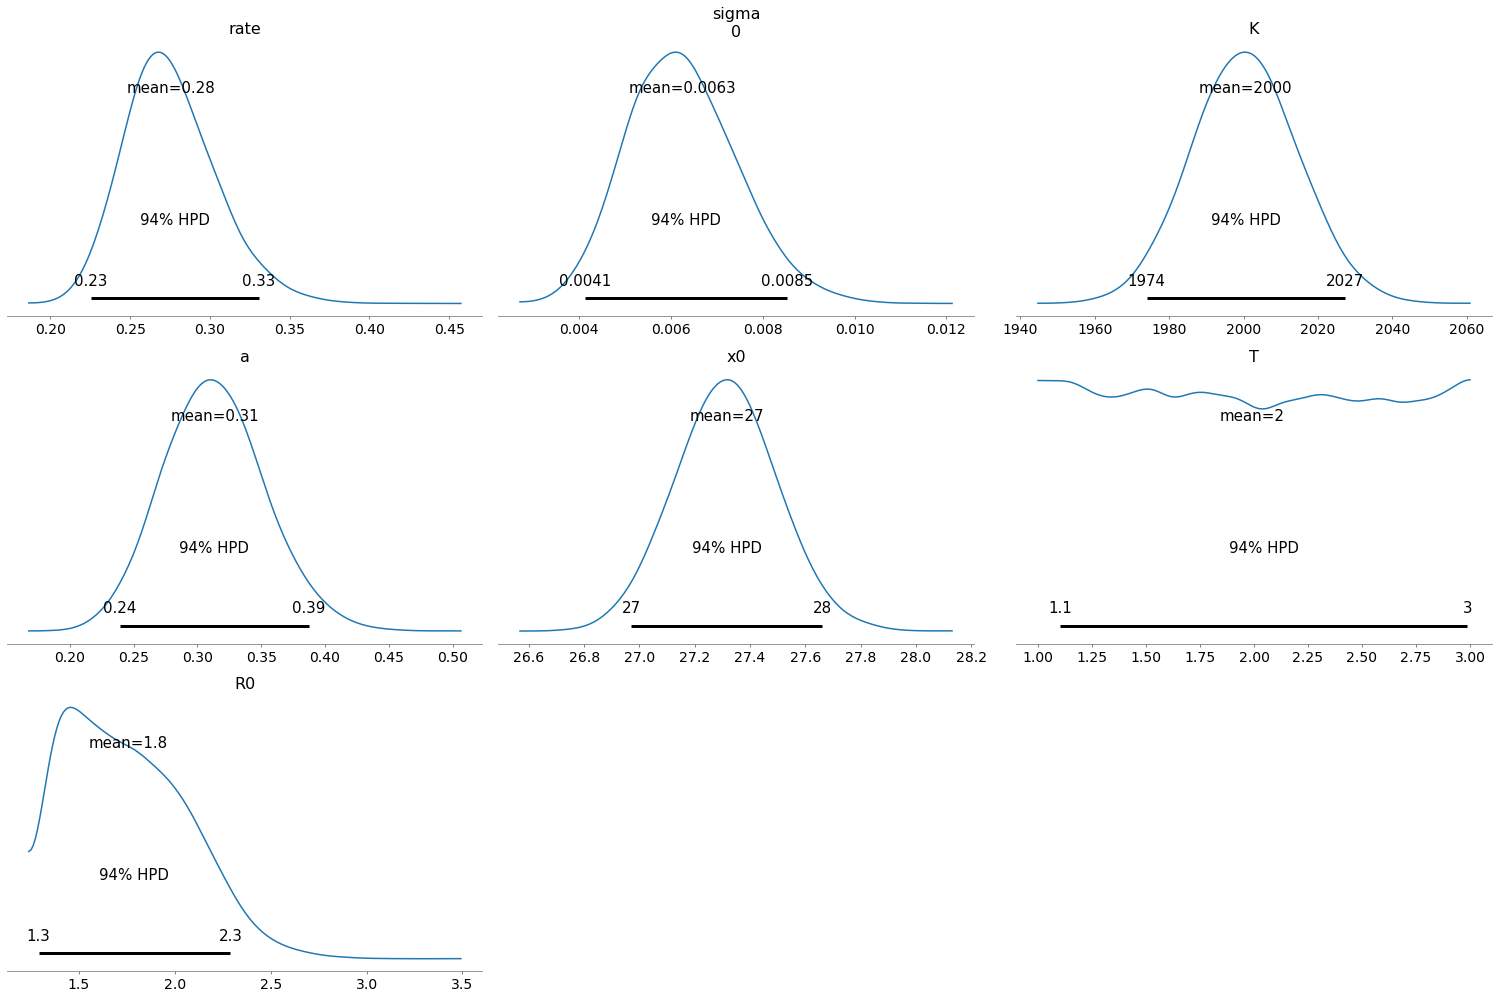

In [10]:
az.plot_posterior(trace);

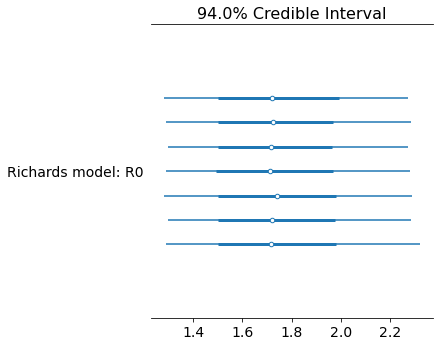

In [11]:
az.plot_forest([trace], model_names=["Richards model"], var_names=['R0']);

In [12]:
# Fitted parameters
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
txt = """
        --------------------------------------
        Fitted parameters for {}:
        --------------------------------------
        Growth rate: {}
        Turning point: {}
        Final size of epidemic: {}
        Basic reproduction number (R0): {}
        --------------------------------------
     """.format(country, *f_values)
print(txt)


        --------------------------------------
        Fitted parameters for Cuba:
        --------------------------------------
        Growth rate: 0.28
        Turning point: 27.32
        Final size of epidemic: 2000.48
        Basic reproduction number (R0): 1.76
        --------------------------------------
     


## Model predictions

In [13]:
# ========== Compute predictions =============
np.random.seed(12345)
tp = int(round(np.percentile(trace['x0'], 50, axis=0)))
h = tp # 27  # number points to prediction ahead
with richards_model:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, len(y_values) + h)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({"x_data": x_data})
    pm.set_data({"y_data": y_data})

    # Sample posterior predictive
    post_pred_final = pm.sample_posterior_predictive(trace, samples=100)

# Prediction of cumulative cases 
y_min_final = np.percentile(post_pred_final['y'], 2.5, axis=0)
y_max_final = np.percentile(post_pred_final['y'], 97.5, axis=0)
y_fit_final = np.percentile(post_pred_final['y'], 50, axis=0)

# Prediction of incidence of new cases
dy_fit_final = np.percentile(trace['rate'], 50, axis=0) * y_fit_final * (1 - (y_fit_final / np.percentile(trace['K'], 50, axis=0)) ** np.percentile(trace['a'], 50, axis=0))

/home/jrd/.local/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 143.70it/s]


In [14]:
from sklearn.metrics import mean_squared_error
rms_train = round(np.sqrt(mean_squared_error(df_train['acumulado'], y_fit_final[df_train[x_data_label]])),2)
rms_test = round(np.sqrt(mean_squared_error(df_test['acumulado'], y_fit_final[df_test[x_data_label]])),2)
print('RMSE-train: {}'.format(rms_train))
print('RMSE-test: {}'.format(rms_test))

RMSE-train: 12.42
RMSE-test: 3.63


### Plot prediction of comulative cases

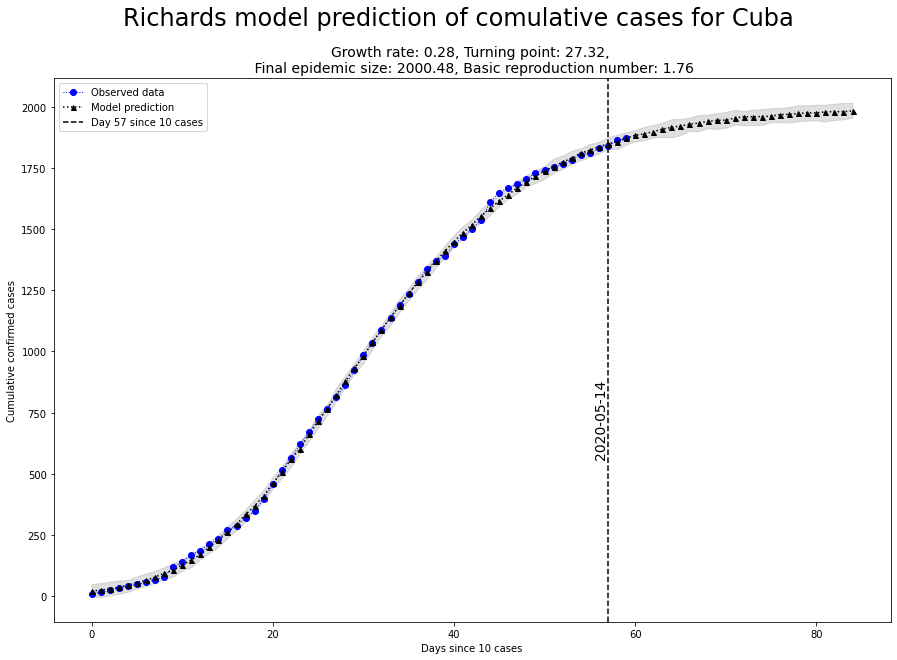

In [15]:
# Plot prediction of comulative cases
#ymax_limit = max(max(y_fit_final), df.acumulado.astype('float64').max()) * 1.10
yref_ycoord_0 = min(np.median(y_fit_final), df.acumulado.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['acumulado'], 'b', marker='o', ls=':', lw=1, label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), y_fit_final,
         'k', marker='^', ls=':', ms=5, mew=1, label='Model prediction')
plt.fill_between(np.arange(0, post_pred_final['y'].shape[1]), y_min_final, y_max_final, color='0.5', alpha=0.25)
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df_train[df_train[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
plt.suptitle('Richards model prediction of comulative cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
ax.set(xlabel='Days since {} cases'.format(epidemic_start))
ax.set(ylabel='Cumulative confirmed cases')
plt.legend(loc='upper left')
# plt.savefig('results/{}/cumulative_prediction_plot.png'.format(country))
plt.show()

### Plot prediction of incidence of new cases

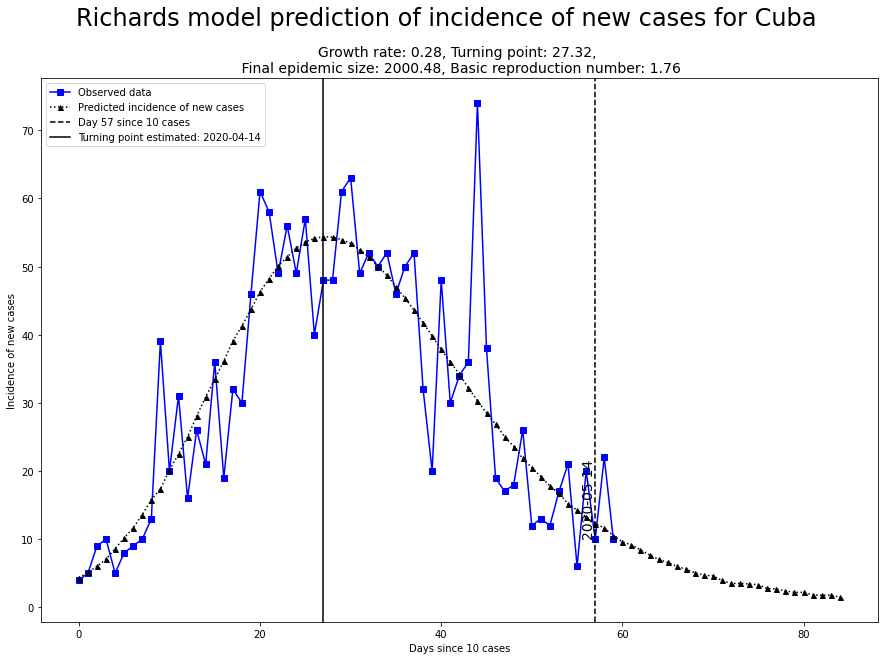

In [16]:
# Incidence of new cases prediction
yref_ycoord_0 = min(np.median(dy_fit_final), df.new_cases.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['new_cases'], 'b', marker='s', ls='-', label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), dy_fit_final, 'k', marker='^', ls=':', ms=5, mew=1,
         label='Predicted incidence of new cases')
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
if tp in list(df[x_data_label].values):
    tp_date = df[df[x_data_label] == tp].date.values[0]
    ax.axvline(tp, ls='-', color='k', label='Turning point estimated: {}'.format(str(tp_date)[:10]))
plt.xlabel('Days since {} cases'.format(epidemic_start))
plt.ylabel('Incidence of new cases')
plt.suptitle('Richards model prediction of incidence of new cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
plt.legend(loc='upper left')
# plt.savefig('results/{}/newcases_prediction_plot.png'.format(country))
plt.show()

## Refit the model with full data

In [87]:
x_values = df[x_data_label].values
y_values = df.acumulado.astype('float64').values
with pm.Model() as richards_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)
    K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
    rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
    a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
    x0 = pm.Uniform('x0', 1, 200, testval=15)
    T = pm.Uniform('T', 1, 3, testval=1.2)
    R0 = pm.Deterministic('R0', np.exp(rate * T))

    # Create likelihood for data
    x_data = pm.Data("x_data", x_values)
    y_data = pm.Data("y_data", y_values)
    mu = K * (1 + np.exp(-rate * a * (x_data - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
    y = pm.Normal('y', mu=mu, tau=sigma, observed=y_data)
    
with richards_model:
    
    # Sample posterior
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(4000, tune=4000, cores=7, start=start, target_accept=.95, random_seed=1234)

logp = -173.56, ||grad|| = 11.061: 100%|██████████| 68/68 [00:00<00:00, 2483.98it/s]    
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [T, x0, a, rate, K, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 56000/56000 [03:42<00:00, 251.91draws/s]
The number of effective samples is smaller than 25% for some parameters.


## Save the model for further analysis

In [17]:
import pickle 

with open('results/Cuba/model_data.pkl', 'wb') as buff:
    pickle.dump({'model': richards_model, 'trace': trace}, buff)